In [1]:
import spherical_inr as sph
import matplotlib.pyplot as plt
import torch
import s2fft
import utils
import numpy as np

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


In [2]:
class ToCart(torch.nn.Module):
    def forward(self, x):
        return sph.transforms.tp_to_r3(x)

In [3]:
shnet_init = torch.nn.Sequential(
    ToCart(),
    sph.RegularHerglotzPE(L = 20, init_exponents=True)
)

shnet_noinit = torch.nn.Sequential(
    ToCart(),
    sph.RegularHerglotzPE(L = 20, init_exponents=False)
)

In [4]:
phi, theta, (nlon, nlat) = utils.sample_s2(L = 50, sampling = "gl")
x = torch.stack([theta.flatten(), phi.flatten()], dim=-1).float()

In [5]:
yinit = shnet_init(x).reshape(nlat, nlon, -1)
ynoinit = shnet_noinit(x).reshape(nlat, nlon, -1)

In [6]:
sh_transforms_init = []

for i in range(yinit.size(-1)):
    yi = yinit[..., i].detach().numpy()
    sh_transform = s2fft.forward_numpy(yi, L = 50, sampling = "gl")
    sh_transforms_init.append(sh_transform)

sh_transforms_init = np.sum(sh_transforms_init, axis=0)

In [7]:
sh_transforms_noinit = []

for i in range(ynoinit.size(-1)):
    yi = ynoinit[..., i].detach().numpy()
    sh_transform = s2fft.forward_numpy(yi, L = 50, sampling = "gl")
    sh_transforms_noinit.append(sh_transform)

sh_transforms_noinit = np.sum(sh_transforms_noinit, axis=0)

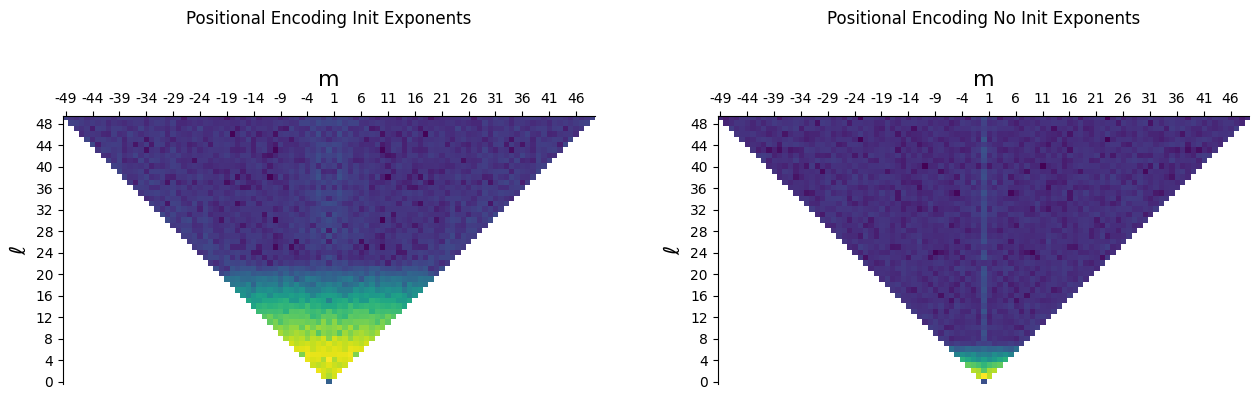

In [8]:
fig = plt.figure(figsize=(12, 5))
subfigs = fig.subfigures(1, 2, hspace=0.01)

im1 = utils.plot_SHT_coeffs(sh_transforms_init, ticks_m=5, ticks_l=4, fig = subfigs[0], cmap = "viridis",)
subfigs[0].suptitle("Positional Encoding Init Exponents")
im2 = utils.plot_SHT_coeffs(sh_transforms_noinit, ticks_m=5, ticks_l=4, fig = subfigs[1], cmap = "viridis")
subfigs[1].suptitle("Positional Encoding No Init Exponents")


plt.show()